## Momentum in Machine Learning

### Gradient Descent
The algorithm has many virtues, but speed is not one of them. It is simple — when optimizing a smooth function ff, we make a small step in the gradient direction.
For a step-size small enough, gradient descent makes a monotonic improvement at every iteration. It always converges, albeit to a local minimum. And under a few weak curvature conditions it can even get there at an exponential rate.

### Momentum

Simply put, the momentum algorithm helps us progress faster in the neural network, negatively or positively, to the ball analogy. This helps us get to a local minimum faster.

### Nesterov Accelerated Gradient (NAG)

Classic momentum is like a ball that is rolling down a hill, blindly following the slope. This is not satisfactory for us, we'd like to have a smarter ball, a ball that has a notion of where it is going so that it knows when to slow down before the hill slopes up again.
Nesterov accelerated gradient (NAG) is a way to give our momentum term this kind of superpower.

### RMSprop
RMSprop is an unpublished, adaptive learning rate method proposed by Geoff Hinton in Lecture 6e of his Coursera Class.

### ADAM
Adam is another adaptive learning rate that is basically combining the idea of classical momentum with RMSprop.




In [31]:
class Optimizer:
    
    def __init__(self, name, lr=0.001, gama=0.9, beta=0.98, epsilon=1e-8):
        self.func = getattr(self, name)
        self.gama = gama
        self.beta = beta
        self.lr = lr
        self.epsilon = epsilon
    
    def optimize(self, gradient):
        return self.func(gradient)
    
    def sgd(self, gradient):
        return (self.lr * gradient)
    
    def momentum(self, gradient):
        if not hasattr(self, 'v_i'): self.v_i = 0
        self.v_i = self.sgd(gradient) + (self.gama * self.v_i)
        return self.v_i
    
    def nag(self, gradient):
        if not hasattr(self, 'v_i'): self.v_i = 0
        self.v_i = self.sgd(gradient) + (self.gama * self.v_i)
        return self.v_i
    
    def rmsprop(self, gradient):
        if not hasattr(self, 'm_t'): self.m_t = 0
        self.m_t = ((1-self.gama)*np.square(gradient)) + (self.gama * self.m_t)
        return self.lr * gradient / np.sqrt(self.epsilon + self.m_t)
    
    def adam(self, gradient):
        if not hasattr(self, 'm_t'): 
            self.m_t = 0
            self.v_t = 0
            self.t = 1
        self.m_t = ((1-self.gama)*gradient) + (self.gama * self.m_t)
        self.v_t = ((1-self.beta)*np.square(gradient)) + (self.beta * self.v_t)
        m_cor = self.m_t / (1 - np.power(self.gama, self.t))
        v_cor = self.v_t / (1 - np.power(self.beta, self.t))
        self.t += 1
        return self.lr * m_cor / (np.sqrt(self.v_t) + self.epsilon)
    

## Multiclass logistic regression implementation

In [55]:
import numpy as np
import matplotlib.pyplot as plt

class MultiClassLogisticRegression:
    
    def __init__(self, n_iter = 10000, thres=1e-3):
        self.n_iter = n_iter
        self.thres = thres
    
    def fit(self, X, y, batch_size=64, lr=0.001, rand_seed=4, verbose=False, optimizer='sgd'): 
        np.random.seed(rand_seed) 
        self.classes = np.unique(y)
        self.class_labels = {c:i for i,c in enumerate(self.classes)}
        X = self.add_bias(X)
        y = self.one_hot(y)
        self.loss = []
        self.weights = np.zeros(shape=(len(self.classes),X.shape[1]))
        self.fit_data(X, y, batch_size, lr, verbose, optimizer)
        return self
 
    def fit_data(self, X, y, batch_size, lr, verbose, optimizer):
        if optimizer == 'nag': 
            optimizer = 'momentum'
        optimizer = Optimizer(optimizer, lr=lr)
        i = 0
        update = 0
        while (not self.n_iter or i < self.n_iter):
            self.loss.append(self.cross_entropy(y, self.predict_(X)))
            idx = np.random.choice(X.shape[0], batch_size)
            X_batch, y_batch = X[idx], y[idx]
            w = self.weights 
            if optimizer == 'nag': w -= (0.9 * update)
            gradient = self.compute_grad(X_batch, y_batch, w)
            update = optimizer.optimize(gradient)
            self.weights -= update
#             if np.abs(update).max() < self.thres: break
            if i % 1000 == 0 and verbose: 
                print(' Training Accuray at {} iterations is {}'.format(i, self.evaluate_(X, y)))
            i +=1
            
    def compute_grad(self, X, y, w):
        probs = self.softmax(np.dot(X, w.T).reshape(-1,len(self.classes)))
        return np.dot((probs - y).T, X)
    
    def predict(self, X):
        return self.predict_(self.add_bias(X))
    
    def predict_(self, X):
        pre_vals = np.dot(X, self.weights.T).reshape(-1,len(self.classes))
        return self.softmax(pre_vals)
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def predict_classes(self, X):
        self.probs_ = self.predict(X)
        return np.vectorize(lambda c: self.classes[c])(np.argmax(self.probs_, axis=1))
  
    def add_bias(self,X):
        return np.insert(X, 0, 1, axis=1)
  
    def get_randon_weights(self, row, col):
        return np.zeros(shape=(row,col))

    def one_hot(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]
    
    def score(self, X, y):
        return np.mean(self.predict_classes(X) == y)
    
    def evaluate_(self, X, y):
        return np.mean(np.argmax(self.predict_(X), axis=1) == np.argmax(y, axis=1))
    
    def cross_entropy(self, y, probs):
        return -1 * np.mean(y * np.log(probs))

## Implementation Evaluation

In [56]:
def train_model(X_train, X_test, y_train, y_test, optimizer='sgd', lr=0.0001):
    model = MultiClassLogisticRegression()
    model.fit(X_train,y_train,lr=lr, optimizer=optimizer)
    print(optimizer.upper() + ' Evaluation Score ', model.score(X_test,y_test))
    return model


def plot(x, y1, y2, sub, label1, label2):
    aux = plt.subplot(sub)
    plt.title("Loss during training")
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.plot(x, y1, 'r--', y2)
    aux.legend([label1, label2])

('SGD Evaluation Score ', 0.9333333333333333)
('MOMENTUM Evaluation Score ', 0.9666666666666667)
('NAG Evaluation Score ', 0.9666666666666667)


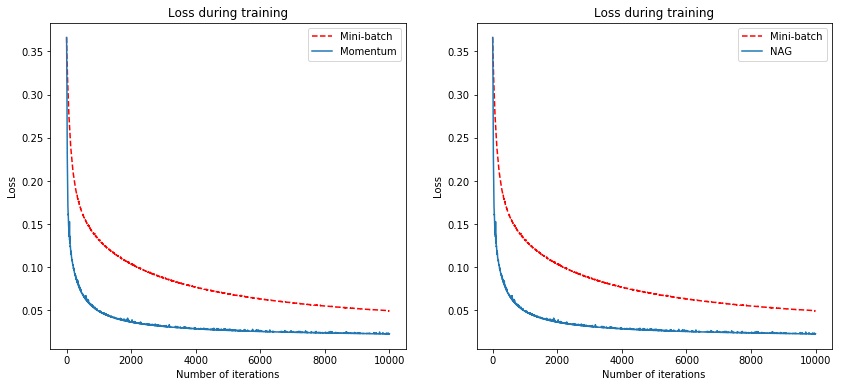

In [59]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
X,y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr = train_model(X_train, X_test, y_train, y_test)
lr_moment = train_model(X_train, X_test, y_train, y_test, optimizer='momentum')
lr_nag = train_model(X_train, X_test, y_train, y_test, optimizer='nag')

fig = plt.figure(figsize=(14,6))
plot(np.arange(len(lr.loss)), lr.loss, lr_moment.loss, 121, 'Mini-batch', 'Momentum')
plot(np.arange(len(lr.loss)), lr.loss, lr_nag.loss, 122, 'Mini-batch', 'NAG')

('ADAM Evaluation Score ', 1.0)
('RMSPROP Evaluation Score ', 1.0)


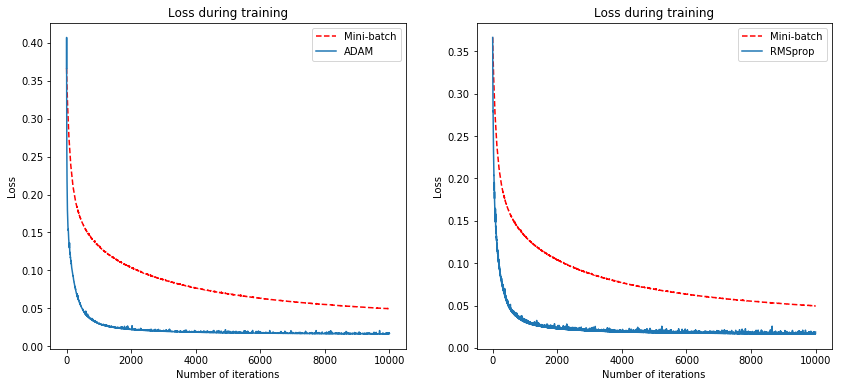

In [60]:
lr_adam = train_model(X_train, X_test, y_train, y_test, optimizer='adam', lr=0.01)
lr_rms = train_model(X_train, X_test, y_train, y_test, optimizer='rmsprop', lr=0.01)

fig = plt.figure(figsize=(14,6))
plot(np.arange(len(lr.loss)), lr.loss, lr_adam.loss, 121, 'Mini-batch', 'ADAM')
plot(np.arange(len(lr.loss)), lr.loss, lr_rms.loss, 122, 'Mini-batch', 'RMSprop')

('SGD Evaluation Score ', 0.975)
('MOMENTUM Evaluation Score ', 0.9777777777777777)
('NAG Evaluation Score ', 0.9777777777777777)


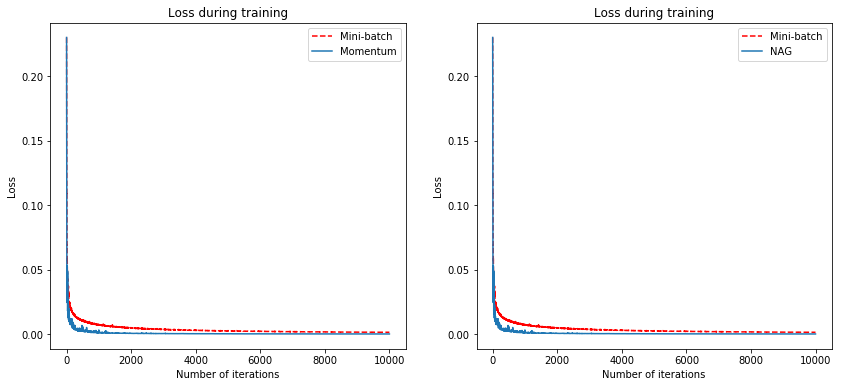

In [61]:
from sklearn import datasets
import matplotlib.pyplot as plt

X, y = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr = train_model(X_train, X_test, y_train, y_test)
lr_moment = train_model(X_train, X_test, y_train, y_test, optimizer='momentum')
lr_nag = train_model(X_train, X_test, y_train, y_test, optimizer='nag')

fig = plt.figure(figsize=(14,6))
plot(np.arange(len(lr.loss)), lr.loss, lr_moment.loss, 121, 'Mini-batch', 'Momentum')
plot(np.arange(len(lr.loss)), lr.loss, lr_nag.loss, 122, 'Mini-batch', 'NAG')

('ADAM Evaluation Score ', 0.9777777777777777)
('RMSPROP Evaluation Score ', 0.9777777777777777)


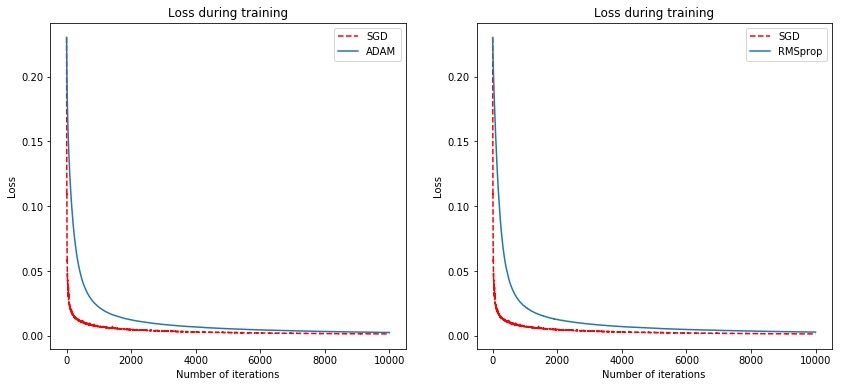

In [62]:
lr_adam = train_model(X_train, X_test, y_train, y_test, optimizer='adam')
lr_rms = train_model(X_train, X_test, y_train, y_test, optimizer='rmsprop')

fig = plt.figure(figsize=(14,6))
plot(np.arange(len(lr.loss)), lr.loss, lr_adam.loss, 121, 'SGD', 'ADAM')
plot(np.arange(len(lr.loss)), lr.loss, lr_rms.loss, 122, 'SGD', 'RMSprop')

('ADAM Evaluation Score ', 0.9666666666666667)
('RMSPROP Evaluation Score ', 0.9638888888888889)


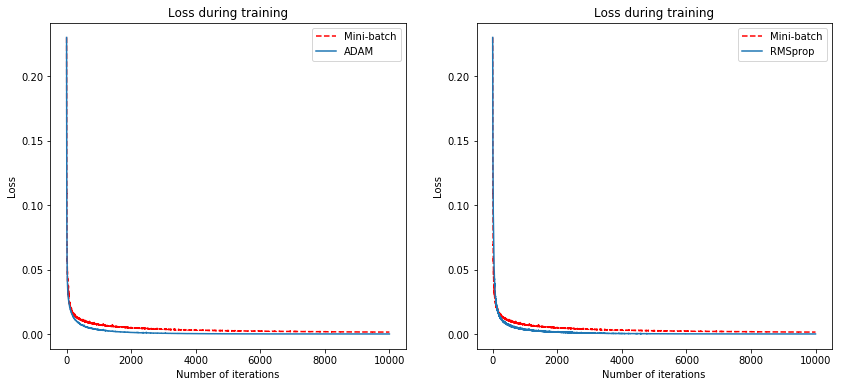

In [64]:
lr_adam = train_model(X_train, X_test, y_train, y_test, optimizer='adam', lr=0.001)
lr_rms = train_model(X_train, X_test, y_train, y_test, optimizer='rmsprop', lr=0.001)

fig = plt.figure(figsize=(14,6))
plot(np.arange(len(lr.loss)), lr.loss, lr_adam.loss, 121, 'Mini-batch', 'ADAM')
plot(np.arange(len(lr.loss)), lr.loss, lr_rms.loss, 122, 'Mini-batch', 'RMSprop')